In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader


In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # for ResNet50
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [47]:
train_dataset = datasets.ImageFolder("/kaggle/input/brain-tumor-mri-dataset/Training", transform=transform)
test_dataset  = datasets.ImageFolder("/kaggle/input/brain-tumor-mri-dataset/Testing", transform=transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,      
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)
num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# normal resnet 50

In [9]:
model = models.resnet50(pretrained=True)

# Freeze backbone (for first experiment)
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, num_classes)
)

model = model.to(device)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)


In [11]:
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Loss: {running_loss/len(train_loader):.4f} "
          f"Accuracy: {100*correct/total:.2f}%")


Epoch [1/10] Loss: 0.6543 Accuracy: 75.73%
Epoch [2/10] Loss: 0.4564 Accuracy: 82.91%
Epoch [3/10] Loss: 0.4231 Accuracy: 84.18%
Epoch [4/10] Loss: 0.3786 Accuracy: 85.98%
Epoch [5/10] Loss: 0.3976 Accuracy: 84.91%
Epoch [6/10] Loss: 0.3804 Accuracy: 85.59%
Epoch [7/10] Loss: 0.3754 Accuracy: 85.80%
Epoch [8/10] Loss: 0.3887 Accuracy: 85.61%
Epoch [9/10] Loss: 0.3721 Accuracy: 86.12%
Epoch [10/10] Loss: 0.3684 Accuracy: 86.29%


In [15]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100*correct/total:.2f}%")


Test Accuracy: 77.75%


# normal Efficient net b4

In [16]:
transform_b4 = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [17]:
model = models.efficientnet_b4(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.classifier[1].in_features, num_classes)
)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)


In [18]:
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Loss: {running_loss/len(train_loader):.4f} "
          f"Accuracy: {100*correct/total:.2f}%")


Epoch [1/10] Loss: 0.8876 Accuracy: 72.54%
Epoch [2/10] Loss: 0.5910 Accuracy: 80.43%
Epoch [3/10] Loss: 0.5142 Accuracy: 82.45%
Epoch [4/10] Loss: 0.4755 Accuracy: 83.68%
Epoch [5/10] Loss: 0.4505 Accuracy: 83.89%
Epoch [6/10] Loss: 0.4293 Accuracy: 84.98%
Epoch [7/10] Loss: 0.4199 Accuracy: 84.27%
Epoch [8/10] Loss: 0.4194 Accuracy: 84.46%
Epoch [9/10] Loss: 0.4076 Accuracy: 85.09%
Epoch [10/10] Loss: 0.4068 Accuracy: 85.02%


In [19]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100*correct/total:.2f}%")


Test Accuracy: 81.19%


# Fine tune Res net 50

In [23]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 4)
)
for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True
    model = model.to(device)

In [24]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4   # 🔥 lower than before
)

In [25]:
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Loss: {running_loss/len(train_loader):.4f} "
          f"Accuracy: {100*correct/total:.2f}%")


Epoch [1/10] Loss: 0.2712 Accuracy: 90.25%
Epoch [2/10] Loss: 0.0592 Accuracy: 98.09%
Epoch [3/10] Loss: 0.0306 Accuracy: 98.98%
Epoch [4/10] Loss: 0.0170 Accuracy: 99.46%
Epoch [5/10] Loss: 0.0183 Accuracy: 99.50%
Epoch [6/10] Loss: 0.0174 Accuracy: 99.52%
Epoch [7/10] Loss: 0.0127 Accuracy: 99.61%
Epoch [8/10] Loss: 0.0094 Accuracy: 99.71%
Epoch [9/10] Loss: 0.0160 Accuracy: 99.54%
Epoch [10/10] Loss: 0.0104 Accuracy: 99.73%


In [26]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100*correct/total:.2f}%")


Test Accuracy: 94.75%


# Fine tune Efficient net b4


In [33]:
model = models.efficientnet_b4(pretrained=True)

In [34]:
for param in model.parameters():
    param.requires_grad = False


In [35]:
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.classifier[1].in_features, 4)
)


In [36]:
for param in model.features[-2:].parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True
model = model.to(device)

In [37]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)


In [38]:
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Loss: {running_loss/len(train_loader):.4f} "
          f"Accuracy: {100*correct/total:.2f}%")


Epoch [1/10] Loss: 1.0255 Accuracy: 63.82%
Epoch [2/10] Loss: 0.4944 Accuracy: 81.50%
Epoch [3/10] Loss: 0.3826 Accuracy: 85.55%
Epoch [4/10] Loss: 0.3297 Accuracy: 87.57%
Epoch [6/10] Loss: 0.2601 Accuracy: 90.27%
Epoch [7/10] Loss: 0.2339 Accuracy: 91.55%
Epoch [8/10] Loss: 0.2170 Accuracy: 91.77%
Epoch [9/10] Loss: 0.1986 Accuracy: 92.14%
Epoch [10/10] Loss: 0.1810 Accuracy: 93.34%


In [39]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100*correct/total:.2f}%")


Test Accuracy: 89.62%


# With Scheduling Resnet 50 fine tuned

In [48]:

transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

transform_effnet = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

In [59]:
def train_resnet():

    train_dataset = datasets.ImageFolder("/kaggle/input/brain-tumor-mri-dataset/Training", transform=transform_resnet)
    test_dataset  = datasets.ImageFolder("/kaggle/input/brain-tumor-mri-dataset/Testing", transform=transform_resnet)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    model = models.resnet50(pretrained=True)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Replace classifier
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model.fc.in_features, 4)
    )

    # Unfreeze last block
    for param in model.layer4.parameters():
        param.requires_grad = True

    for param in model.fc.parameters():
        param.requires_grad = True

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-4
    )

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=2
    )

    best_acc = 0
    epochs = 12

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total

        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"TrainLoss: {train_loss/len(train_loader):.4f} "
              f"ValLoss: {val_loss/len(val_loader):.4f} "
              f"ValAcc: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_resnet50.pth")

    print("Best Val Accuracy:", best_acc)


# efficient net with scheduler

In [67]:
def train_efficientnet():

    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torchvision import datasets, models
    from torch.utils.data import DataLoader

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_dataset = datasets.ImageFolder(
        "/kaggle/input/brain-tumor-mri-dataset/Training",
        transform=transform_effnet
    )

    test_dataset = datasets.ImageFolder(
        "/kaggle/input/brain-tumor-mri-dataset/Testing",
        transform=transform_effnet
    )

    train_loader = DataLoader(
        train_dataset, batch_size=16, shuffle=True,
        num_workers=8, pin_memory=True
    )

    val_loader = DataLoader(
        test_dataset, batch_size=16, shuffle=False,
        num_workers=8, pin_memory=True
    )

    # ---------------- MODEL ----------------
    model = models.efficientnet_b4(
        weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1
    )

    # Freeze all
    for param in model.parameters():
        param.requires_grad = False

    # Replace classifier
    model.classifier = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(model.classifier[1].in_features, 4)
    )

    # Unfreeze last feature block
    for param in model.features[-1].parameters():
        param.requires_grad = True

    for param in model.classifier.parameters():
        param.requires_grad = True

    model = model.to(device)

    # ---------------- LOSS + OPT ----------------
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=5e-5,
        weight_decay=1e-4
    )

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.2,
        patience=2,
        verbose=True
    )

    best_acc = 0
    epochs = 12

    # ---------------- TRAIN LOOP ----------------
    for epoch in range(epochs):

        model.train()
        train_loss = 0

        for images, labels in train_loader:

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()

            # IMPORTANT for EfficientNet stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            train_loss += loss.item()

        # ---------------- VALIDATION ----------------
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:

                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total

        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"TrainLoss: {train_loss/len(train_loader):.4f} "
              f"ValLoss: {val_loss/len(val_loader):.4f} "
              f"ValAcc: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_efficientnet_b4.pth")

    print("Best Val Accuracy:", best_acc)


In [61]:
train_resnet()

Epoch [1/12] TrainLoss: 0.2644 ValLoss: 0.3743 ValAcc: 91.19%
Epoch [2/12] TrainLoss: 0.0700 ValLoss: 0.2838 ValAcc: 94.12%
Epoch [3/12] TrainLoss: 0.0289 ValLoss: 0.2683 ValAcc: 94.88%
Epoch [4/12] TrainLoss: 0.0108 ValLoss: 0.3024 ValAcc: 95.12%
Epoch [5/12] TrainLoss: 0.0142 ValLoss: 0.3529 ValAcc: 94.31%
Epoch [6/12] TrainLoss: 0.0124 ValLoss: 0.2964 ValAcc: 94.69%
Epoch [7/12] TrainLoss: 0.0053 ValLoss: 0.2962 ValAcc: 94.75%
Epoch [8/12] TrainLoss: 0.0037 ValLoss: 0.3302 ValAcc: 94.69%
Epoch [9/12] TrainLoss: 0.0027 ValLoss: 0.2956 ValAcc: 94.88%
Epoch [10/12] TrainLoss: 0.0019 ValLoss: 0.3118 ValAcc: 94.75%
Epoch [11/12] TrainLoss: 0.0029 ValLoss: 0.3189 ValAcc: 94.94%
Epoch [12/12] TrainLoss: 0.0029 ValLoss: 0.3215 ValAcc: 94.81%
Best Val Accuracy: 95.125


In [66]:
train_efficientnet()

Epoch [1/12] TrainLoss: 1.2602 ValLoss: 331.4708 ValAcc: 72.75%
Epoch [2/12] TrainLoss: 1.0279 ValLoss: 451.6226 ValAcc: 73.06%
Epoch [3/12] TrainLoss: 0.8303 ValLoss: 499.4650 ValAcc: 75.94%


KeyboardInterrupt: 

In [69]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from torchvision import models, transforms
from PIL import Image

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


In [70]:
def load_image(img_path, size):
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],
                             [0.229,0.224,0.225])
    ])

    img = Image.open(img_path).convert("RGB")
    rgb_img = np.array(img.resize((size, size))) / 255.0
    input_tensor = transform(img).unsqueeze(0)

    return rgb_img, input_tensor


In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet50(pretrained=False)
resnet.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(resnet.fc.in_features, 4)
)

resnet.load_state_dict(torch.load("best_resnet50.pth", map_location=device))
resnet = resnet.to(device)
resnet.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [92]:
def gradcam_resnet(img_path):
    
    rgb_img, input_tensor = load_image(img_path, 224)
    input_tensor = input_tensor.to(device)

    target_layers = [resnet.layer3[-1]]



    cam = GradCAM(model=resnet, target_layers=target_layers)

    targets = None  # highest scoring class

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0]

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.imshow(visualization)
    plt.axis('off')
    plt.show()


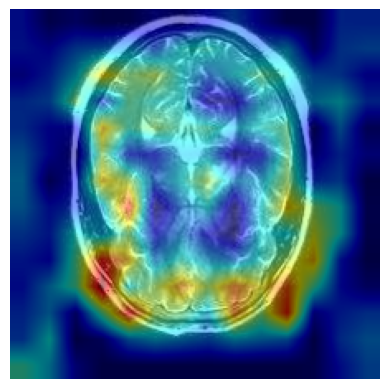

In [84]:
gradcam_resnet("/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_10.jpg")


# retring resnet 50 with tighter transforms

In [85]:
from torchvision import transforms

# ImageNet normalization (since using pretrained ResNet)
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

transform_resnet_train = transforms.Compose([
    transforms.CenterCrop(300),                # remove excess skull/background
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_resnet_test = transforms.Compose([
    transforms.CenterCrop(300),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [88]:
def train_resnet():

    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torchvision import datasets, models
    from torch.utils.data import DataLoader

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_dataset = datasets.ImageFolder(
        "/kaggle/input/brain-tumor-mri-dataset/Training",
        transform=transform_resnet
    )

    test_dataset = datasets.ImageFolder(
        "/kaggle/input/brain-tumor-mri-dataset/Testing",
        transform=transform_resnet
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    val_loader = DataLoader(
        test_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    # ---------------- MODEL ----------------
    model = models.resnet50(
        weights=models.ResNet50_Weights.IMAGENET1K_V1
    )

    # Freeze everything first
    for param in model.parameters():
        param.requires_grad = False

    # Replace classifier
    model.fc = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(model.fc.in_features, 4)
    )

    # Unfreeze deeper layers (better MRI adaptation)
    for param in model.layer4.parameters():
        param.requires_grad = True

    for param in model.layer3.parameters():
        param.requires_grad = True

    for param in model.fc.parameters():
        param.requires_grad = True

    model = model.to(device)

    # ---------------- LOSS ----------------
    criterion = nn.CrossEntropyLoss()

    # Smaller LR for fine-tuning medical data
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-5,
        weight_decay=1e-4
    )

    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=12
    )

    best_acc = 0
    epochs = 20

    # ---------------- TRAIN LOOP ----------------
    for epoch in range(epochs):

        model.train()
        train_loss = 0

        for images, labels in train_loader:

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()

            # Stabilizes fine-tuning
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            train_loss += loss.item()

        scheduler.step()

        # ---------------- VALIDATION ----------------
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:

                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"TrainLoss: {train_loss/len(train_loader):.4f} "
              f"ValLoss: {val_loss/len(val_loader):.4f} "
              f"ValAcc: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_resnet50.pth")

    print("Best Val Accuracy:", best_acc)


In [89]:
train_resnet()

Epoch [1/20] TrainLoss: 0.6157 ValLoss: 0.4018 ValAcc: 86.25%
Epoch [2/20] TrainLoss: 0.1753 ValLoss: 0.2856 ValAcc: 92.44%
Epoch [3/20] TrainLoss: 0.0694 ValLoss: 0.2437 ValAcc: 94.12%
Epoch [4/20] TrainLoss: 0.0285 ValLoss: 0.2797 ValAcc: 93.88%
Epoch [5/20] TrainLoss: 0.0157 ValLoss: 0.3015 ValAcc: 93.88%
Epoch [6/20] TrainLoss: 0.0086 ValLoss: 0.2962 ValAcc: 94.44%
Epoch [7/20] TrainLoss: 0.0056 ValLoss: 0.3221 ValAcc: 94.25%
Epoch [8/20] TrainLoss: 0.0068 ValLoss: 0.3158 ValAcc: 94.31%
Epoch [9/20] TrainLoss: 0.0027 ValLoss: 0.3586 ValAcc: 94.25%
Epoch [10/20] TrainLoss: 0.0037 ValLoss: 0.3237 ValAcc: 94.38%
Epoch [11/20] TrainLoss: 0.0024 ValLoss: 0.3209 ValAcc: 94.38%
Epoch [12/20] TrainLoss: 0.0026 ValLoss: 0.3336 ValAcc: 94.31%
Epoch [13/20] TrainLoss: 0.0023 ValLoss: 0.3225 ValAcc: 94.38%
Epoch [14/20] TrainLoss: 0.0031 ValLoss: 0.3134 ValAcc: 94.44%
Epoch [15/20] TrainLoss: 0.0024 ValLoss: 0.3209 ValAcc: 94.19%
Epoch [16/20] TrainLoss: 0.0026 ValLoss: 0.3219 ValAcc: 94.31%
E

KeyboardInterrupt: 

# highest Epoch [6/20] TrainLoss: 0.0086 ValLoss: 0.2962 ValAcc: 94.44%


# GradCam

In [129]:
def gradcam_resnet(img_path, actual_class=None):
    rgb_img, input_tensor = load_image(img_path, 224)
    input_tensor = input_tensor.to(device)

    # Forward pass to get prediction
    with torch.no_grad():
        outputs = resnet(input_tensor)
        _, pred_idx = outputs.max(1)
        predicted_class = classes[pred_idx.item()]

    # Grad-CAM
    target_layers = [resnet.layer2[-1]]
    cam = GradCAM(model=resnet, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor, targets=None)
    grayscale_cam = grayscale_cam[0]

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Display image
    plt.imshow(visualization)
    plt.axis('off')
    plt.show()

    # Right or Wrong check
    result = None
    if actual_class is not None:
        result = "Right" if predicted_class == actual_class else "Wrong"
        print(f"Predicted class: {predicted_class}, Actual class: {actual_class}, Result: {result}")
    else:
        print(f"Predicted class: {predicted_class} (Actual class not provided)")

    return predicted_class, result, visualization


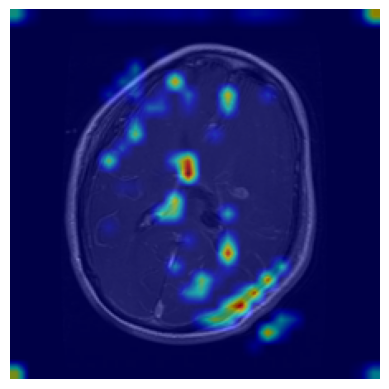

Predicted class: class0, Actual class: class0, Result: Right


In [133]:
pred, result,vis= gradcam_resnet("/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_10.jpg", actual_class="class0")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting evaluation...


Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.81      0.89       400
  meningioma       0.90      0.97      0.93       400
     notumor       0.92      1.00      0.96       400
   pituitary       0.98      0.99      0.99       400

    accuracy                           0.94      1600
   macro avg       0.95      0.94      0.94      1600
weighted avg       0.95      0.94      0.94      1600

Confusion Matrix:
[[324  42  32   2]
 [  3 390   1   6]
 [  0   0 400   0]
 [  0   3   0 397]]


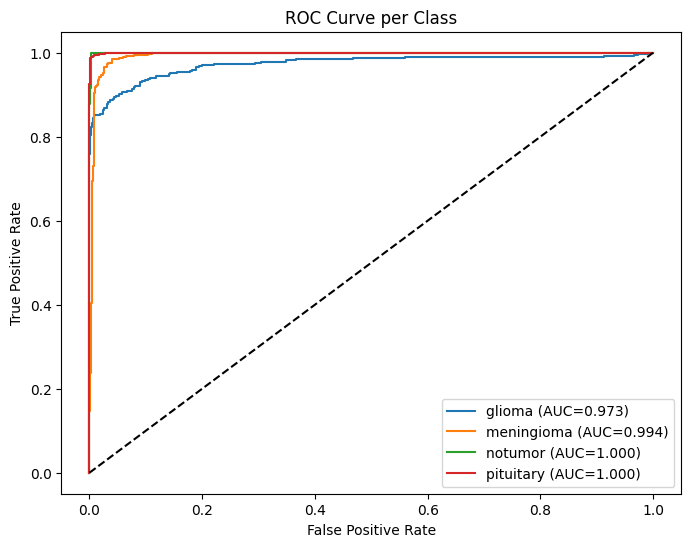


Evaluation complete! Grad-CAM images saved to: gradcam_outputs


In [140]:
import os
import torch
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# ----------------- CONFIG -----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 224
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']  # your 4 classes
idx2class = {i:c for i,c in enumerate(classes)}  # map index → class name

model_path = "best_resnet50.pth"
test_folder = "/kaggle/input/brain-tumor-mri-dataset/Testing"  # folder with subfolders 'glioma', 'meningioma', etc.
gradcam_save_dir = "gradcam_outputs"
os.makedirs(gradcam_save_dir, exist_ok=True)

# ----------------- MODEL -----------------
resnet = models.resnet50(pretrained=False)
resnet.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(resnet.fc.in_features, len(classes))
)
resnet.load_state_dict(torch.load(model_path, map_location=device))
resnet = resnet.to(device)
resnet.eval()

# ----------------- IMAGE LOADER -----------------
def load_image(img_path, size=224):
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
    img = Image.open(img_path).convert("RGB")
    rgb_img = np.array(img.resize((size, size))) / 255.0
    input_tensor = transform(img).unsqueeze(0)
    return rgb_img, input_tensor

# ----------------- EVALUATION -----------------
y_true = []
y_pred = []
y_scores = []

print("Starting evaluation...\n")

for class_name in classes:
    class_folder = os.path.join(test_folder, class_name)
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        rgb_img, input_tensor = load_image(img_path, img_size)
        input_tensor = input_tensor.to(device)

        # ----------------- PREDICTION -----------------
        with torch.no_grad():
            outputs = resnet(input_tensor)
            probs = F.softmax(outputs, dim=1)
            pred_idx = outputs.argmax(1).item()
            y_pred.append(pred_idx)
            y_true.append(classes.index(class_name))
            y_scores.append(probs.cpu().numpy()[0])

        pred_class_name = idx2class[pred_idx]
        result = "Right" if pred_idx == classes.index(class_name) else "Wrong"

        #print(f"{img_name}: Predicted={pred_class_name}, Actual={class_name}, {result}, Prob={probs[0,pred_idx]:.3f}")

        # ----------------- GRAD-CAM -----------------
        target_layers = [resnet.layer3[-1]]  # last conv layer
        cam = GradCAM(model=resnet, target_layers=target_layers)
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # Save Grad-CAM visualization
        save_path = os.path.join(gradcam_save_dir, f"{class_name}_{img_name}")
        plt.imsave(save_path, visualization)

# ----------------- CLASSIFICATION REPORT -----------------
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# ----------------- CONFUSION MATRIX -----------------
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# ----------------- ROC CURVES & AUC -----------------
y_true_onehot = np.eye(len(classes))[y_true]  # one-hot encode
y_scores = np.array(y_scores)

plt.figure(figsize=(8,6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class")
plt.legend()
plt.show()

print("\nEvaluation complete! Grad-CAM images saved to:", gradcam_save_dir)
